# Helper functions for the de-dispersion code

### Jul 31, 2020

## Code

In [1]:
import sys
import csv
# sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
# sys.path.append("/users/PCON0003/cond0068/pyrex_sims/fromBen/thesis_work/pyrex-custom/analysis/custom/analysis/")
import ROOT
import math
import numpy as np
from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib.pyplot as plt
from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import pyrex
# import pyrex.custom.analysis
# import pyrex.custom.araroot as araroot



Welcome to JupyROOT 6.18/04


In [65]:
import pyrex.custom.ara as ara
from pyrex.internal_functions import (normalize, complex_bilinear_interp,
                                      complex_interp)

In [272]:
# ara_antenna = ara.antenna.VPOL_RESPONSE_DATA
VPOL_DATA_FILE = os.path.join(ara.antenna.ARA_DATA_DIR,
                              "ARA_bicone6in_output_MY_fixed.txt")
VPOL_THETA_RESPONSE_DATA = ara.antenna._read_arasim_antenna_data(VPOL_DATA_FILE)
VPOL_RESPONSE_DATA = (
    VPOL_THETA_RESPONSE_DATA[0],
    np.zeros(VPOL_THETA_RESPONSE_DATA[0].shape),
    *VPOL_THETA_RESPONSE_DATA[1:]
)
ara_antenna = VPOL_RESPONSE_DATA

theta_response = ara_antenna[0]
phi_response = ara_antenna[1]
response_freqs = ara_antenna[2]
response_zens = ara_antenna[3]
response_azis = ara_antenna[4]

In [273]:
def directional_response(theta, phi, polarization):
        """
        Generate the (complex) frequency-dependent directional response.
        For given angles and polarization direction, use the model of the
        directional and polarization gains of the antenna to generate a
        function for the interpolated response of the antenna with respect to
        frequency. Used with the `frequency_response` method to calculate
        effective heights.
        Parameters
        ----------
        theta : float
            Polar angle (radians) from which a signal is arriving.
        phi : float
            Azimuthal angle (radians) from which a signal is arriving.
        polarization : array_like
            Normalized polarization vector in the antenna coordinate system.
        Returns
        -------
        function
            A function which returns complex-valued voltage gains for given
            frequencies, using the values of incoming angle and polarization.
        See Also
        --------
        ARAAntenna.frequency_response : Calculate the (complex) frequency
                                        response of the antenna.
        """
        e_theta = [np.cos(theta) * np.cos(phi),
                   np.cos(theta) * np.sin(phi),
                   -np.sin(theta)]
        e_phi = [-np.sin(phi), np.cos(phi), 0]
        theta_factor = np.dot(polarization, e_theta)
        phi_factor = np.dot(polarization, e_phi)
        theta_gains = complex_bilinear_interp(
            x=np.degrees(theta), y=np.degrees(phi),
            xp=response_zens,
            yp=response_azis,
            fp=theta_response,
            method='cartesian'
        )
        phi_gains = complex_bilinear_interp(
            x=np.degrees(theta), y=np.degrees(phi),
            xp=response_zens,
            yp=response_azis,
            fp=phi_response,
            method='cartesian'
        )
        freq_interpolator = lambda frequencies: complex_interp(
            x=frequencies, xp=response_freqs,
            fp=theta_factor*theta_gains + phi_factor*phi_gains,
            method='euler', outer=0
        )
        return freq_interpolator
    
def frequency_response(frequencies):
    """
    Calculate the (complex) frequency response of the antenna.
    Rather than handling the entire frequency response of the antenna, this
    method is being used to convert the frequency-dependent gains from the
    `directional_response` method into effective heights.
    Parameters
    ----------
    frequencies : array_like
        1D array of frequencies (Hz) at which to calculate gains.
    Returns
    -------
    array_like
        Complex gains in voltage for the given `frequencies`.
    See Also
    --------
    ARAAntenna.directional_response : Generate the (complex) frequency
                                      dependent directional response.
    """
    # From AraSim GaintoHeight function, with gain calculation moved to
    # the directional_response method.
    # gain=4*pi*A_eff/lambda^2 and h_eff=2*sqrt(A_eff*Z_rx/Z_air)
    # Then 0.5 to calculate power with heff (cancels 2 above)
    heff = np.zeros(len(frequencies))
    # The index of refraction in this calculation should be the index of
    # the ice used in the production of the antenna model.
    n = 1.78
    heff[frequencies!=0] = np.sqrt((3e8/frequencies[frequencies!=0]/n)**2
                                   * n*50/377 /(4*np.pi))
    return heff

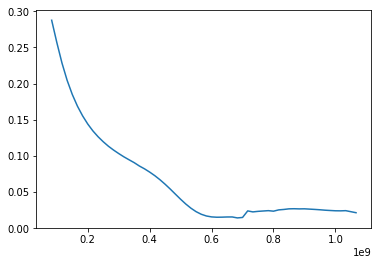

In [295]:
theta = np.deg2rad(90)
phi = np.deg2rad(0)
dir_res = abs(directional_response(theta,phi,np.array([0,0, 1]))(response_freqs))
heff = dir_res * frequency_response(response_freqs)
plt.plot(response_freqs,heff)


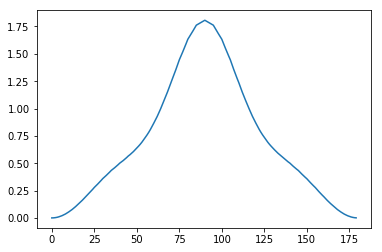

In [290]:
# response_freqs[15]/1E6
theta = np.array([np.deg2rad(angle) for angle in range(0,180)])
response = []
for theta_in in theta:
    response.append(complex_bilinear_interp(
            x=np.degrees(theta_in), y=np.degrees(phi),
            xp=response_zens,
            yp=response_azis,
            fp=theta_response,
            method='cartesian'
            )[19])
plt.plot(np.rad2deg(theta),abs(np.array(response))*abs(np.array(response)))


In [234]:
def read_ARA_antenna_model(finame):
    fi = open(finame, 'r')
    rdr = csv.reader(fi, delimiter=' ', skipinitialspace=True)
    freq = 0.
    SWR = 999.
    impedance = 0.
    table = []
    for row in rdr:
    #    print(row)
        if( row[0] == 'freq'):
            freq = float(row[2])
        elif( row[0] == 'SWR'):
            SWR = float(row[2])
#         elif( row[0] == 'Impedance'):
#             impedance = float(row[2])
        elif( row[0] == 'Theta' ):
            continue
        else:
            theta = float(row[0])
            phi = float(row[2])
            gaindb= float(row[4])
            gain = float(row[6])
            phase = float(row[8])
            row = {'freq':freq, 'SWR':SWR, 'theta':theta, 'phi':phi, 'gaindb':gaindb, 'gain':gain, 'phase':phase}
#             print(row)
            table.append(row)
    return pd.DataFrame(table)

In [235]:
bicone = read_ARA_antenna_model("/users/PCON0003/cond0068/ARA/AraSim/ARA_bicone6in_output.txt")
dipole = read_ARA_antenna_model("/users/PCON0003/cond0068/ARA/AraSim/ARA_dipoletest1_output.txt")

ValueError: could not convert string to float: 

In [213]:
borehole_bicone = bicone.loc[(bicone['phi']==90) & (bicone['theta']==90)]
borehole_dipole = dipole.loc[(dipole['phi']==90) & (dipole['theta']==90)]

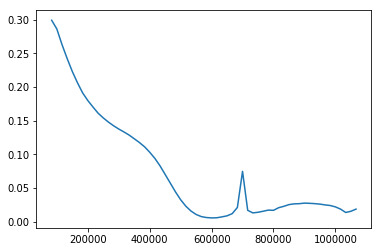

In [304]:
freqs = borehole_bicone.freq.unique()*1E3
plt.plot(freqs,frequency_response(freqs)*borehole_bicone["gain"]/1000)

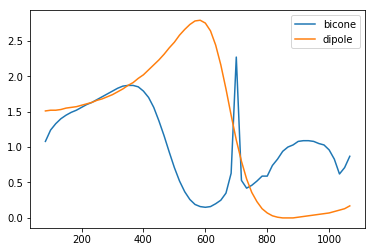

In [215]:
plt.plot(borehole_bicone["freq"], borehole_bicone["gain"], label = "bicone")
plt.plot(borehole_dipole["freq"], borehole_dipole["gain"], label = "dipole")
plt.legend()

### Antenna gain as a function of theta at 400 MHz

In [216]:
bicone.freq.unique()

array([  83.33,  100.  ,  116.67,  133.33,  150.  ,  166.67,  183.34,
        200.  ,  216.67,  233.34,  250.  ,  266.67,  283.34,  300.  ,
        316.67,  333.34,  350.  ,  366.67,  383.34,  400.01,  416.67,
        433.34,  450.01,  466.67,  483.34,  500.01,  516.68,  533.34,
        550.01,  566.68,  583.34,  600.01,  616.68,  633.34,  650.01,
        666.68,  683.35,  700.01,  716.68,  733.35,  750.01,  766.68,
        783.35,  800.01,  816.68,  833.35,  850.02,  866.68,  883.35,
        900.02,  916.68,  933.35,  950.02,  966.68,  983.35, 1000.  ,
       1016.7 , 1033.4 , 1050.  , 1066.7 ])

In [217]:
at400MHz = bicone.loc[(bicone['phi']==90) & (bicone['freq']==400.01)]
at400MHz_dipole = dipole.loc[(dipole['phi']==90) & (dipole['freq']==400.01)]


In [218]:
at400MHz.tail()

,freq,SWR,theta,phi,gaindb,gain,phase
51314,400.01,1.87,160.0,90.0,-7.27,0.19,-46.43
51315,400.01,1.87,165.0,90.0,-9.47,0.11,-43.95
51316,400.01,1.87,170.0,90.0,-12.78,0.05,-42.23
51317,400.01,1.87,175.0,90.0,-18.67,0.01,-41.23
51318,400.01,1.87,180.0,90.0,-57.17,0.00,177.37


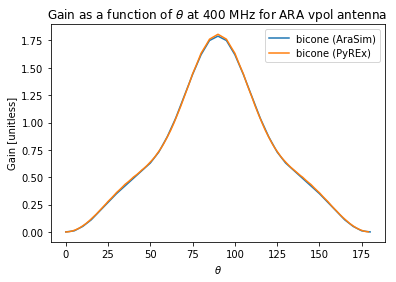

In [276]:
plt.plot(at400MHz.theta, at400MHz.gain, label = "bicone (AraSim)")
# plt.plot(at400MHz_dipole.theta, at400MHz_dipole.gain, label = "dipole")
plt.plot(np.rad2deg(theta),abs(np.array(response))*abs(np.array(response)),label = "bicone (PyREx)")

plt.ylabel("Gain [unitless]")
plt.xlabel("$\\theta$")
plt.title("Gain as a function of $\\theta$ at 400 MHz for ARA vpol antenna ")
plt.legend()

## Examine pickle

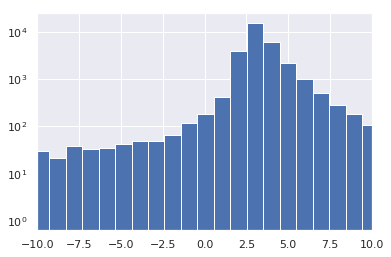

In [36]:
unpickled_df = pd.read_pickle("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes/angles.pkl")
unpickled_df = unpickled_df.dropna()
# plt.hist(unpickled_df["theta_antenna"]-unpickled_df["theta_reco"])
plt.hist(unpickled_df["theta_antenna"]-unpickled_df["theta_reco"], bins=300);
plt.xlim(-10,10)
plt.yscale('log')

In [38]:
mean = (unpickled_df["theta_antenna"]-unpickled_df["theta_reco"]).mean()

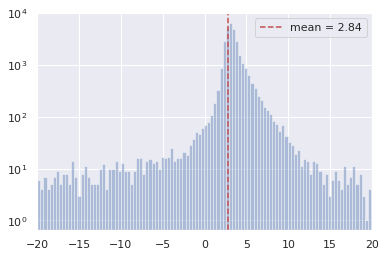

In [49]:
import seaborn as sns
from scipy import stats
plt.axvline(mean, color='r', linestyle='--', label = "mean = %0.2f"%mean)
sns.set(color_codes=True)
sns.distplot(unpickled_df["theta_antenna"]-unpickled_df["theta_reco"], bins=800, kde=False);
plt.xlim(-20,20)
plt.yscale('log')
plt.legend()

## Debug FFT

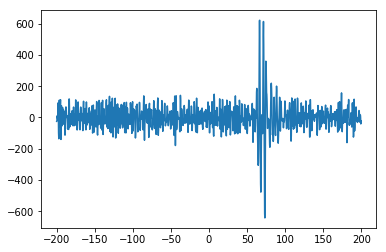

In [333]:
wform = pd.read_pickle("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes/wform_forDebug.pkl")
plt.plot(wform["time"], wform.voltage)


In [334]:
import scipy
fft = abs(scipy.fft.rfft(np.array(wform["voltage"])))
freq = 1000*scipy.fft.rfftfreq(n=len(wform["time"]), d=wform["time"][1]-wform["time"][0])

(0, 1000)

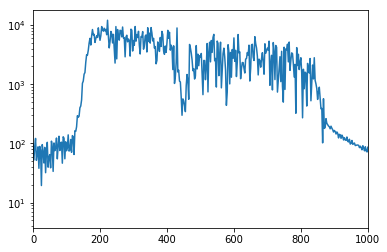

In [337]:
plt.plot(freq,fft, label="Direct")
plt.yscale('log')
plt.xlim(0,1000)

## Plots

## Comments